In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optimizers
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

#np.random.seed(9837)
#torch.manual_seed(9837)

In [2]:
# 多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

# 切断ポアソン分布を生成する関数
def rtpois(mu, a, b, n, flag=0):
    FA = scipy.stats.poisson.cdf(a, mu)
    FB = scipy.stats.poisson.cdf(b, mu)
    x = np.array(scipy.stats.poisson.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu), dtype="int")
    if flag==1:
        x = torch.Tensor(x)
    return x

# 切断ポアソン分布を高速で生成する関数
def rtpois_lw(mu, a, b, N, flag=0):
    x = np.random.poisson(mu, N)
    index = np.where(x==0)[0]
    x[index] = rtpois(mu[index], a, b, index.shape[0], 0)
    if flag==1:
        x = torch.Tensor(x)
    return x

# ガンマ分布を生成する関数
def Gamma(w1, w2, flag=0):
    x = np.random.gamma(w1, w2)
    if flag==1:
        x = torch.Tensor(x)
    return x

# 学習データの生成

In [3]:
# データの生成
# データの定義
modes = 3   #モード数
k1 = 12
k2 = 10
k3 = 7
hh = 5000   
item = 3000   
context = 250 
Lambda = np.random.gamma(50.0, 1/0.2, hh)
pt = np.random.poisson(Lambda, hh)   #モードあたりのレコード数
N = np.sum(pt)
k_vec = [np.repeat(1, k1), np.repeat(1, k2), np.repeat(1, k3)]

In [4]:
# IDとインデックスを作成
# IDの定義
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

# インデックスの定義
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [5]:
# アイテムの生成
# 多項分布からトピックを生成
topic = 30
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), hh)
phi_item = np.random.dirichlet(np.repeat(0.2, item), topic)
phi_context = np.random.dirichlet(np.repeat(0.2, context), topic)
z = rmnom(theta_topic[d_id, ], N, topic, 0)

# トピックからアイテムを生成
item_id = np.repeat(0, N)
for i in range(hh):
    index = d_list[i]
    item_id[index] = rmnom(phi_item[z[index], ], pt[i], item, 0)
    
# インデックスの定義
item_list = [i for i in range(item)]
item_n = np.repeat(0, item)
for i in range(item):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")
    item_n[i] = item_list[i].shape[0]

In [6]:
# contextの生成
# トピックからcontextを生成
context_id = np.repeat(0, N)
for i in range(hh):
    index = d_list[i]
    context_id[index] = rmnom(phi_context[z[index], ], pt[i], context, 0)
    
# インデックスの定義
context_list = [i for i in range(context)]
context_n = np.repeat(0, context)
for i in range(context):
    context_list[i] = np.array(np.where(context_id==i)[0], dtype="int")
    context_n[i] = context_list[i].shape[0]

In [7]:
# 学習データの応答変数を生成
rp = 0
max_freq = 500
while True:
    
    # パラメータを生成
    beta_u = np.random.gamma(1.5, 1.5, hh)
    beta_v = np.random.gamma(0.5, 2.25, item)
    theta_u = np.random.gamma(0.15, 1.7, k1*hh).reshape(hh, k1)
    theta_v = np.random.gamma(0.15, 1.7, k2*item).reshape(item, k2)
    theta_e = np.random.gamma(0.15, 1.5, k3*context).reshape(context, k3)
    omega = np.random.gamma(0.15, 1.0, k1*k2*k3).reshape(k1, k2, k3)
    betat_u = beta_u.copy(); betat_v = beta_v.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_e = theta_e.copy()
    omegat = omega.copy()

    # タッカー分解の期待値
    uv = np.repeat(0.0, N)
    theta_item = theta_v[item_id, ]
    theta_context = theta_e[context_id, ]
    for j in range(k3):
        uv += np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], k_vec[1])
    
    # Bernoulli Poisson linkからbinaryデータを生成
    freq = np.random.poisson(uv, N)
    y = np.array(freq > 0, dtype="int")
    index_y = np.array(np.where(freq > 0)[0], dtype="int")
    index_z = np.array(np.where(freq==0)[0], dtype="int")
    M = index_y.shape[0]
    
    # break条件
    print([rp, np.max(freq)])
    rp += 1
    if np.max(freq) < max_freq:
        break

[0, 550]
[1, 716]
[2, 696]
[3, 1060]
[4, 414]


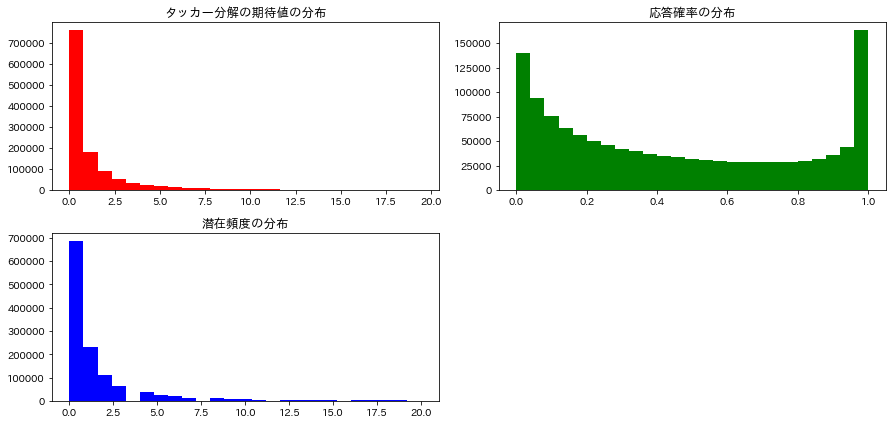

In [8]:
#生成したデータを可視化
Prob = 1 - scipy.stats.poisson.cdf(0, uv)
dt = [uv, Prob, freq]
fig_range = np.append(np.repeat(0.0, len(dt)), 
                      np.array([np.percentile(uv, 99.0), 1.0, np.percentile(freq, 99.0)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["タッカー分解の期待値の分布", "応答確率の分布", "潜在頻度の分布"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

# 検証データの生成

In [9]:
# 検証データの生成
# データの定義
pt0 = np.random.poisson(Lambda, hh)   #モードあたりのレコード数
N0 = np.sum(pt0)

# IDとインデックスを作成
# IDの定義
d_id0 = np.repeat(np.arange(hh), pt0)
pt_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))

# インデックスの定義
d_list0 = [i for i in range(hh)]
for i in range(hh):
    d_list0[i] = np.array(np.where(d_id0==i)[0], dtype="int")

In [10]:
# アイテムとcontextを生成
# トピックからアイテムを生成
z = rmnom(theta_topic[d_id0, ], N0, topic, 0)
item_id0 = np.repeat(0, N0)
for i in range(hh):
    index = d_list0[i]
    item_id0[index] = rmnom(phi_item[z[index], ], pt0[i], item, 0)

# トピックからcontextを生成
context_id0 = np.repeat(0, N0)
for i in range(hh):
    index = d_list0[i]
    context_id0[index] = rmnom(phi_context[z[index], ], pt0[i], context, 0)

In [11]:
# 検証データの応答変数を生成
# タッカー分解の期待値
uv = np.repeat(0.0, N0)
theta_item = theta_v[item_id0, ]
theta_context = theta_e[context_id0, ]
for j in range(k3):
    uv += np.dot(np.dot(theta_u, omega[:, :, j])[d_id0, ] * theta_item * theta_context[:, j][:, np.newaxis], k_vec[1])

# Bernoulli Poisson linkからbinaryデータを生成
freq0 = np.random.poisson(uv, N0)
y0 = np.array(freq0 > 0, dtype="int")
index_y0 = np.array(np.where(y0==1)[0], dtype="int")
index_z0 = np.array(np.where(y0==0)[0], dtype="int")
M0 = index_y0.shape[0]

# モデルの推定

In [12]:
# アルゴリズムの設定
R = 1000
keep = 2
burnin = 250
skeep = int(burnin/keep)
iter = 0
disp = 10
L = 3

In [13]:
# データを定義
# 定数を定義
long_vec = np.repeat(1.0, k1*k2)
total_freq = np.sum(freq)
index_allocation1 = np.repeat(np.arange(k1), k2)
index_allocation2 = np.tile(np.arange(k2), k1)
mode_block1 = np.diag(np.repeat(1.0, k1))[index_allocation1, ]
mode_block2 = np.diag(np.repeat(1.0, k2))[index_allocation2, ]
mode_block3 = np.repeat(1.0, k1*k2)

# 新しいidを定義
d_id_ = d_id[index_y]
item_id_ = item_id[index_y]
context_id_ = context_id[index_y]

# インデックスを定義
d_list_ = [i for i in range(hh)]
item_list_ = [i for i in range(item)]
context_list_ = [i for i in range(context)]

for i in range(hh):
    d_list_[i] = np.array(np.where(d_id_==i)[0], dtype="int")
for i in range(item):
    item_list_[i] = np.array(np.where(item_id_==i)[0], dtype="int")
for i in range(context):
    context_list_[i] = np.array(np.where(context_id_==i)[0], dtype="int")

In [14]:
# 事前分布の定義
s0 = 1.0
v0 = 1.0
alpha1 = 0.1; beta1 = 0.1
alpha2 = 0.25; beta2 = 0.25

In [15]:
# パラメータの真値
# モデルパラメータの真値
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_e = thetat_e.copy()
omega = omegat.copy()

# パラメータの設定
theta_user = theta_u[d_id, ]; theta_user_ = theta_u[d_id_, ]
theta_item = theta_v[item_id, ]; theta_item_ = theta_v[item_id_, ]
theta_context = theta_e[context_id, ]; theta_context_ = theta_e[context_id_, ]

# モデルの期待値の真値
k_vec = [np.repeat(1, k1), np.repeat(1, k2), np.repeat(1, k3)]
uv = np.zeros((N))
for j in range(k3):
    uv += np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], k_vec[1])
uvt = uv.copy()

In [25]:
# パラメータの初期値
# モデルパラメータの初期値
beta_u = np.random.gamma(2.0, 0.5, hh)
beta_v = np.random.gamma(2.0, 0.5, item)
theta_u = np.random.gamma(1.0, 0.25, k1*hh).reshape(hh, k1)
theta_v = np.random.gamma(1.0, 0.25, k2*item).reshape(item, k2)
theta_e = np.random.gamma(1.0, 0.25, k3*context).reshape(context, k3)
omega = np.random.gamma(1.0, 0.25, k1*k2*k3).reshape(k1, k2, k3)

# パラメータの設定
theta_user = theta_u[d_id, ]; theta_user_ = theta_u[d_id_, ]
theta_item = theta_v[item_id, ]; theta_item_ = theta_v[item_id_, ]
theta_context = theta_e[context_id, ]; theta_context_ = theta_e[context_id_, ]

# モデルの期待値の初期値
k_vec = [np.repeat(1, k1), np.repeat(1, k2), np.repeat(1, k3)]
uv = np.zeros((N))
for j in range(k3):
    uv += np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], k_vec[1])

In [26]:
# サンプリング結果の格納用配列
RS = np.arange(skeep, int(R/keep))
rs = RS.shape[0]
BETA_U = np.zeros((rs, hh))
BETA_V = np.zeros((rs, item))
THETA_U = np.zeros((hh, k1, rs))
THETA_V = np.zeros((item, k2, rs))
THETA_E = np.zeros((context, k3, rs))
OMEGA = np.zeros((k1, k2, k3, rs))

In [27]:
# 学習データの対数尤度の基準値
# 1パラメータモデルの対数尤度
Prob = np.mean(y)
LLst_train = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
print(LLst_train)

# 真値での対数尤度
thetat_item = thetat_v[item_id, ]
thetat_context = thetat_e[context_id, ]
uv = np.repeat(0.0, N)
for j in range(k3):
    uv += np.dot(np.dot(thetat_u, omegat[:, :, j])[d_id, ] * thetat_item * thetat_context[:, j][:, np.newaxis], k_vec[1])
Prob = 1 - np.exp(-uv)
Prob[Prob==1.0] = 0.9999999; Prob[Prob==0.0] = np.power(10.0, -10)
LLbest_train = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
print(LLbest_train)

# テストデータの対数尤度の基準値
# 1パラメータモデルの対数尤度
Prob = np.mean(y0)
LLst_val = np.sum(y0*np.log(Prob) + (1-y0)*np.log(1-Prob))
print(LLst_val)

# 真値での対数尤度
thetat_item = thetat_v[item_id0, ]
thetat_context = thetat_e[context_id0, ]
uv = np.repeat(0.0, N0)
for j in range(k3):
    uv += np.dot(np.dot(thetat_u, omegat[:, :, j])[d_id0, ] * thetat_item * thetat_context[:, j][:, np.newaxis], k_vec[1])
Prob = 1 - np.exp(-uv)
Prob[Prob==1.0] = 0.9999999; Prob[Prob==0.0] = np.power(10.0, -10)
LLbest_val = np.sum(y0*np.log(Prob) + (1-y0)*np.log(1-Prob))
print(LLbest_val)

-860741.9117466678
-488487.814882569
-859609.5574668606
-489099.7092484298


In [31]:
# ギブスサンプリングでパラメータをサンプリング
for rp in range(R):
    
    # Bernoulli-Poisson linkで潜在頻度を生成
    # 期待値を定義
    uv_deploy = np.zeros((M, k1))
    lambda_h = np.zeros((N, k1))
    for j in range(k1):
        lambda_deploy = np.dot(theta_v, omega[j, :, :])[item_id, ] * theta_context
        lambda_h[:, j] = np.dot(lambda_deploy, k_vec[2])
        uv_deploy[:, j] = np.dot(lambda_deploy[index_y, ] * theta_user_[:, j][:, np.newaxis], k_vec[2])
    uv = np.dot(uv_deploy, k_vec[0])

    # 切断ポアソン分布から潜在頻度を生成
    xy = np.repeat(0, N)
    x = rtpois_lw(uv, 0, np.inf, M, 0)
    xy[index_y] = x
    
    # ユーザーパラメータをサンプリング
    # 補助変数lambdaを更新
    Lambda = uv_deploy / uv[:, np.newaxis]

    # 事後分布のパラメータ
    lambda_y = Lambda * x[:, np.newaxis]
    W1 = np.zeros((hh, k1)); W2 = np.zeros((hh, k1))
    for i in range(hh):
        index1 = d_list_[i]; index2 = d_list[i]
        W1[i, ] = lambda_y[index1, ].sum(0) + alpha1 
        W2[i, ] = lambda_h[index2, ].sum(0) + beta1

    # ガンマ分布から事後分布をサンプリング
    theta_u = Gamma(W1, 1/W2, 0)
    theta_user = theta_u[d_id, ]
    theta_user_ = theta_u[d_id_, ]


    # アイテムパラメータをサンプリング
    # 補助変数lambdaを更新
    uv_deploy = np.zeros((M, k2))
    lambda_h = np.zeros((N, k2))
    for j in range(k2):
        lambda_deploy = np.dot(theta_u, omega[:, j, :])[d_id, ] * theta_context
        lambda_h[:, j] = np.dot(lambda_deploy, k_vec[2])
        uv_deploy[:, j] = np.dot(lambda_deploy[index_y, ] * theta_item_[:, j][:, np.newaxis], k_vec[2])
    uv = np.dot(uv_deploy, k_vec[1])

    # 補助変数lambdaを更新
    Lambda = uv_deploy / uv[:, np.newaxis]

    # 事後分布のパラメータ
    lambda_y = Lambda * x[:, np.newaxis]
    W1 = np.zeros((item, k2)); W2 = np.zeros((item, k2))
    for i in range(item):
        index1 = item_list_[i]; index2 = item_list[i]
        W1[i, ] = lambda_y[index1, ].sum(0) + alpha1 
        W2[i, ] = lambda_h[index2, ].sum(0) + beta1

    # ガンマ分布から事後分布をサンプリング
    theta_v = Gamma(W1, 1/W2, 0)
    theta_item = theta_v[item_id, ]
    theta_item_ = theta_v[item_id_, ]


    # コンテキストパラメータをサンプリング
    # 補助変数lambdaを更新
    uv_deploy = np.zeros((M, k3))
    lambda_h = np.zeros((N, k3))
    for j in range(k3):
        lambda_deploy = np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item
        lambda_h[:, j] = np.dot(lambda_deploy, k_vec[1])
        uv_deploy[:, j] = np.dot(lambda_deploy[index_y, ] * theta_context_[:, j][:, np.newaxis], k_vec[1])
    uv = np.dot(uv_deploy, k_vec[2])

    # 補助変数lambdaを更新
    Lambda = uv_deploy / uv[:, np.newaxis]

    # 事後分布のパラメータ
    lambda_y = Lambda * x[:, np.newaxis]
    W1 = np.zeros((context, k3))
    W2 = np.zeros((context, k3))
    for i in range(context):
        index1 = context_list_[i]; index2 = context_list[i]
        W1[i, ] = lambda_y[index1, ].sum(0) + alpha1 
        W2[i, ] = lambda_h[index2, ].sum(0) + beta1

    # ガンマ分布から事後分布をサンプリング
    theta_e = Gamma(W1, 1/W2, 0)
    theta_context = theta_e[context_id, ]
    theta_context_ = theta_e[context_id_, ]
    
    
    # コアテンソルをサンプリング
    # 補助変数lambdaを更新
    mu_block1 = np.zeros((k1, k2, k3))
    mu_block2 = np.zeros((k1, k2, k3))
    theta_deploy = theta_u[:, index_allocation1][d_id, ] * theta_v[:, index_allocation2][item_id, ]
    for j in range(k3):
        theta_modes = theta_deploy * theta_context[:, j][:, np.newaxis]
        mu_block1[:, :, j] = theta_modes.sum(0).reshape(k1, k2)
        mu_block2[:, :, j] = theta_modes[index_y, ].sum(0).reshape(k1, k2)
    omega_block = omega * mu_block2
    Lambda = omega_block / omega_block.sum()

    # 事後分布をサンプリング
    w1 = Lambda * x.sum() + alpha2
    w2 = mu_block1 + beta2
    omega = Gamma(w1, 1/w2, 0)


    # サンプリング結果の格納と表示
    if (rp%keep==0) & (rp >= burnin):
        mkeep = int(rp/keep) - skeep
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_E[:, :, mkeep] = theta_e
        OMEGA[:, :, :, mkeep] = omega

    if rp%disp==0:
        # 学習データの対数尤度
        uv = np.zeros((N))
        for j in range(k3):
            uv += np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], k_vec[1])
        Prob = 1 - np.exp(-uv)
        Prob[Prob==1.0] = 0.9999999; Prob[Prob==0.0] = 10.0**-10
        LL_train = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))

        # 学習データの対数尤度
        theta_item0 = theta_v[item_id0, ]
        theta_context0 = theta_e[context_id0, ]
        uv0 = np.zeros((N0))
        for j in range(k3):
            uv0 += np.dot(np.dot(theta_u, omega[:, :, j])[d_id0, ] * theta_item0 * theta_context0[:, j][:, np.newaxis], k_vec[1])
        Prob = 1 - np.exp(-uv0)
        Prob[Prob==1.0] = 0.9999999; Prob[Prob==0.0] = 10.0**-10
        LL_val = np.sum(y0*np.log(Prob) + (1-y0)*np.log(1-Prob))

        #サンプリング結果を表示
        print(rp)
        print(["学習データの対数尤度:", np.round(LL_train, 1), "学習データの真値の対数尤度:", np.round(LLbest_train, 1)])
        print(["テストデータの対数尤度:", np.round(LL_val, 1), "テストデータの真値の対数尤度:", np.round(LLbest_val, 1)])

0
['学習データの対数尤度:', -614742.7, '学習データの真値の対数尤度:', -488487.8]
['テストデータの対数尤度:', -621648.9, 'テストデータの真値の対数尤度:', -489099.7]
Wall time: 2min 10s


# PyTorch Tensorを用いたモデルの推定

In [35]:
# 事前分布の定義
s0 = 1.0
v0 = 1.0
alpha1 = 1.0; beta1 = 1.0
alpha2 = 2.5; beta2 = 2.5

In [36]:
# パラメータの初期値
# モデルパラメータの初期値
beta_u = torch.Tensor(np.random.gamma(2.0, 0.5, hh))
beta_v = torch.Tensor(np.random.gamma(2.0, 0.5, item))
theta_u = torch.Tensor(np.random.gamma(1.0, 0.25, k1*hh).reshape(hh, k1))
theta_v = torch.Tensor(np.random.gamma(1.0, 0.25, k2*item).reshape(item, k2))
theta_e = torch.Tensor(np.random.gamma(1.0, 0.25, k3*context).reshape(context, k3))
omega = torch.Tensor(np.random.gamma(1.0, 0.25, k1*k2*k3).reshape(k1, k2, k3))

# パラメータの設定
theta_user = theta_u[d_id, ]; theta_user_ = theta_u[d_id_, ]
theta_item = theta_v[item_id, ]; theta_item_ = theta_v[item_id_, ]
theta_context = theta_e[context_id, ]; theta_context_ = theta_e[context_id_, ]

# モデルの期待値の初期値
k_vec = [np.repeat(1, k1), np.repeat(1, k2), np.repeat(1, k3)]
k_vec = [torch.Tensor(k_vec[i]) for i in range(modes)]
uv = torch.zeros((N))
for j in range(k3):
    uv += torch.mv(torch.mm(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], k_vec[1])

In [39]:
# サンプリング結果の格納用配列
RS = torch.arange(skeep, int(R/keep))
rs = RS.shape[0]
BETA_U = torch.zeros((rs, hh))
BETA_V = torch.zeros((rs, item))
THETA_U = torch.zeros((hh, k1, rs))
THETA_V = torch.zeros((item, k2, rs))
THETA_E = torch.zeros((context, k3, rs))
OMEGA = torch.zeros((k1, k2, k3, rs))

In [43]:
# ギブスサンプリングでパラメータをサンプリング
for rp in range(R):
    
    # Bernoulli-Poisson linkで潜在頻度を生成
    # 期待値を定義
    uv_deploy = torch.zeros((M, k1))
    lambda_h = torch.zeros((N, k1))
    for j in range(k1):
        lambda_deploy = torch.mm(theta_v, omega[j, :, :])[item_id, ] * theta_context
        lambda_h[:, j] = torch.mv(lambda_deploy, k_vec[2])
        uv_deploy[:, j] = torch.mv(lambda_deploy[index_y, ] * theta_user_[:, j][:, np.newaxis], k_vec[2])
    uv = torch.mv(uv_deploy, k_vec[0])

    # 切断ポアソン分布から潜在頻度を生成
    xy = torch.zeros((N))
    x = rtpois_lw(uv, 0, np.inf, M, 1)
    xy[index_y] = x
    
    # ユーザーパラメータをサンプリング
    # 補助変数lambdaを更新
    Lambda = uv_deploy / uv[:, np.newaxis]

    # 事後分布のパラメータ
    lambda_y = Lambda * x[:, np.newaxis]
    W1 = torch.zeros((hh, k1)); W2 = torch.zeros((hh, k1))
    for i in range(hh):
        index1 = d_list_[i]; index2 = d_list[i]
        W1[i, ] = lambda_y[index1, ].sum(0) + alpha1 
        W2[i, ] = lambda_h[index2, ].sum(0) + beta1

    # ガンマ分布から事後分布をサンプリング
    theta_u = Gamma(W1, 1/W2, 1)
    theta_user = theta_u[d_id, ]
    theta_user_ = theta_u[d_id_, ]


    # アイテムパラメータをサンプリング
    # 補助変数lambdaを更新
    uv_deploy = torch.zeros((M, k2))
    lambda_h = torch.zeros((N, k2))
    for j in range(k2):
        lambda_deploy = torch.mm(theta_u, omega[:, j, :])[d_id, ] * theta_context
        lambda_h[:, j] = torch.mv(lambda_deploy, k_vec[2])
        uv_deploy[:, j] = torch.mv(lambda_deploy[index_y, ] * theta_item_[:, j][:, np.newaxis], k_vec[2])
    uv = torch.mv(uv_deploy, k_vec[1])

    # 補助変数lambdaを更新
    Lambda = uv_deploy / uv[:, np.newaxis]

    # 事後分布のパラメータ
    lambda_y = Lambda * x[:, np.newaxis]
    W1 = torch.zeros((item, k2)); W2 = torch.zeros((item, k2))
    for i in range(item):
        index1 = item_list_[i]; index2 = item_list[i]
        W1[i, ] = lambda_y[index1, ].sum(0) + alpha1 
        W2[i, ] = lambda_h[index2, ].sum(0) + beta1

    # ガンマ分布から事後分布をサンプリング
    theta_v = Gamma(W1, 1/W2, 1)
    theta_item = theta_v[item_id, ]
    theta_item_ = theta_v[item_id_, ]


    # コンテキストパラメータをサンプリング
    # 補助変数lambdaを更新
    uv_deploy = torch.zeros((M, k3))
    lambda_h = torch.zeros((N, k3))
    for j in range(k3):
        lambda_deploy = torch.mm(theta_u, omega[:, :, j])[d_id, ] * theta_item
        lambda_h[:, j] = torch.mv(lambda_deploy, k_vec[1])
        uv_deploy[:, j] = torch.mv(lambda_deploy[index_y, ] * theta_context_[:, j][:, np.newaxis], k_vec[1])
    uv = torch.mv(uv_deploy, k_vec[2])

    # 補助変数lambdaを更新
    Lambda = uv_deploy / uv[:, np.newaxis]

    # 事後分布のパラメータ
    lambda_y = Lambda * x[:, np.newaxis]
    W1 = torch.zeros((context, k3))
    W2 = torch.zeros((context, k3))
    for i in range(context):
        index1 = context_list_[i]; index2 = context_list[i]
        W1[i, ] = lambda_y[index1, ].sum(0) + alpha1 
        W2[i, ] = lambda_h[index2, ].sum(0) + beta1

    # ガンマ分布から事後分布をサンプリング
    theta_e = Gamma(W1, 1/W2, 1)
    theta_context = theta_e[context_id, ]
    theta_context_ = theta_e[context_id_, ]
    
    
    # コアテンソルをサンプリング
    # 補助変数lambdaを更新
    mu_block1 = torch.zeros((k1, k2, k3))
    mu_block2 = torch.zeros((k1, k2, k3))
    theta_deploy = theta_u[:, index_allocation1][d_id, ] * theta_v[:, index_allocation2][item_id, ]
    for j in range(k3):
        theta_modes = theta_deploy * theta_context[:, j][:, np.newaxis]
        mu_block1[:, :, j] = theta_modes.sum(0).reshape(k1, k2)
        mu_block2[:, :, j] = theta_modes[index_y, ].sum(0).reshape(k1, k2)
    omega_block = omega * mu_block2
    Lambda = omega_block / omega_block.sum()

    # 事後分布をサンプリング
    w1 = Lambda * x.sum() + alpha2
    w2 = mu_block1 + beta2
    omega = Gamma(w1, 1/w2, 1)


    # サンプリング結果の格納と表示
    if (rp%keep==0) & (rp >= burnin):
        mkeep = int(rp/keep) - skeep
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_E[:, :, mkeep] = theta_e
        OMEGA[:, :, :, mkeep] = omega

    if rp%disp==0:
        # 学習データの対数尤度
        uv = torch.zeros((N))
        for j in range(k3):
            uv += torch.mv(torch.mm(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], k_vec[1])
        Prob = 1 - torch.exp(-uv)
        Prob[Prob==1.0] = 0.9999999; Prob[Prob==0.0] = 10.0**-10
        LL_train = (torch.Tensor(y)*torch.log(Prob) + (1-torch.Tensor(y))*torch.log(1-Prob)).sum().numpy()

        # 学習データの対数尤度
        theta_item0 = theta_v[item_id0, ]
        theta_context0 = theta_e[context_id0, ]
        uv0 = torch.zeros((N0))
        for j in range(k3):
            uv0 += torch.mv(torch.mm(theta_u, omega[:, :, j])[d_id0, ] * theta_item0 * theta_context0[:, j][:, np.newaxis], k_vec[1])
        Prob = 1 - torch.exp(-uv0)
        Prob[Prob==1.0] = 0.9999999; Prob[Prob==0.0] = 10.0**-10
        LL_val = (torch.Tensor(y0)*torch.log(Prob) + (1-torch.Tensor(y0))*torch.log(1-Prob)).sum().numpy()

        #サンプリング結果を表示
        print(rp)
        print(["学習データの対数尤度:", np.round(LL_train, 1), "学習データの真値の対数尤度:", np.round(LLbest_train, 1)])
        print(["テストデータの対数尤度:", np.round(LL_val, 1), "テストデータの真値の対数尤度:", np.round(LLbest_val, 1)])

0
['学習データの対数尤度:', -557831.3, '学習データの真値の対数尤度:', -488487.8]
['テストデータの対数尤度:', -564665.0, 'テストデータの真値の対数尤度:', -489099.7]
Wall time: 1min 7s
